<h2 align='center'> <b> Creating AutoML with Azure CLI </b></h2>

Reference : 
1. https://www.youtube.com/playlist?list=PLiQS6N-W1p3m9squzZ2cPgGdH5SBhjY6f
2. https://learn.microsoft.com/en-us/cli/azure/reference-index?view=azure-cli-latest
3. https://learn.microsoft.com/en-us/cli/azure/ml(v1)?view=azure-cli-latest
4. https://github.com/anikch/azure-ml

The whole ideea beehind creating this notebook is to :
1. Showcase how the resources can be created or trigered using Azure CLI 
2. To differenciate between AzureeML SDK workflow and CLI workflow 
3. For CI CD it's quite important to define scripts in CLI for automation as someone will not be there to run the jupyter script as we have done in `Notebook 1 - Azure ML with Python SDK.ipynb' notebook.

Motive of CI-CD : <br>
In CI CD, the pipeline run is to be automated everytime the Azure repository gets updated. <br>
Say, an application is to be built where whenever a new release comes the contribution of multiple developeers are merged into the master branch in guthub. During release the latest master branch is pulled into azure repository and whenever that pull happeens, the CI CD pipeline gets triggered and the whole workflow runs and new changes of the code gets inteegrated to the existing code base (CI) and the new release of the application gets deployed (CD). 

<h3 align="center"> Creating a CI Pipeline </h3>

In CI pipeline the new changes are integrated to the existing codebase for development. <br>
We would first create the entire thing using the classical editor and would not use any yaml file. Later we would try to implement the same using yaml file as it is exportable and codifiable. Obviously as a coder you would be more likely to love backend changes rather than UI drag and drop : )<br>
One advantage of using classical editer is that now we can get an equivalent yaml representation of the same script/process that we add through classical editor. We can copy that and use that in futher workflow. 

### STEP 1 : Specify Python Version for the environment

In Azure Devops navigate to Pipelines ->New Pipeline -> Use Classic Editor ->Repositry where the code resides->Empty Job -> Triggers -> check 'Enable continuous integration'.<br>

Go to Agent Job -> Plus Icon -> Search use python version -> modify it accordingly.<br>

YAML : 
 
    steps:
    - task: UsePythonVersion@0
    displayName: 'Use Python 3.10'
    inputs:
        versionSpec: 3.10.11

<br>

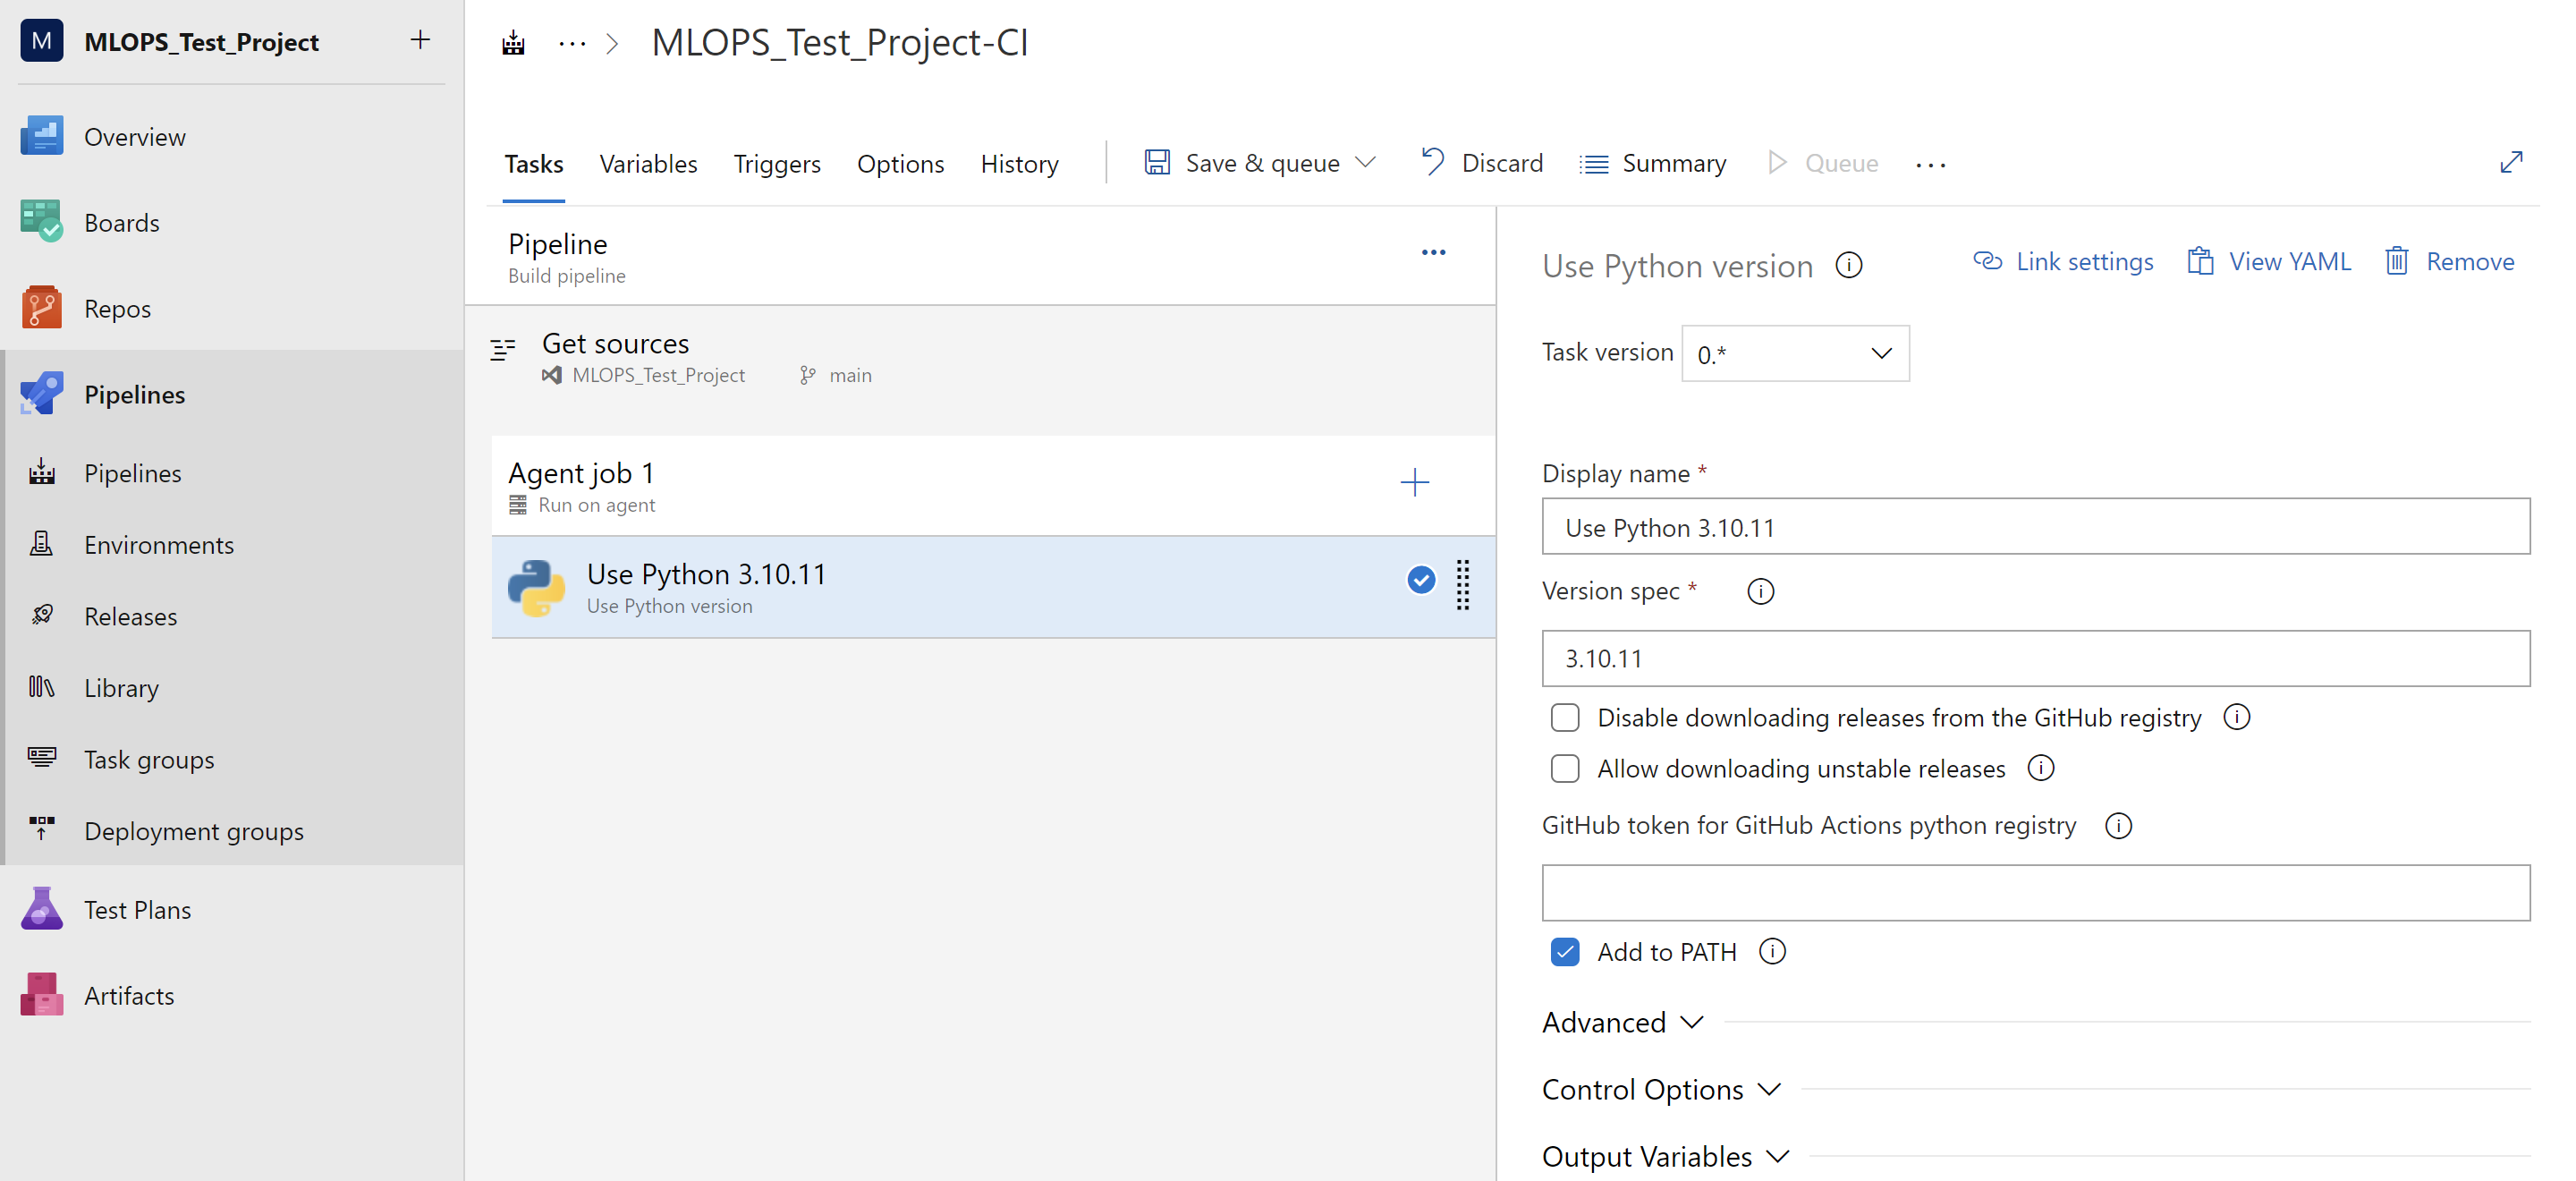

### STEP 2 : Install requirements.txt

The requirement.txt file contains all the libraries and dependencies that would be required to run a app or any ML pipeline. The pythonic dependencies are stored in requirements.txt file which can be executed through requirements.sh shell script. <br>

YAML:

    steps:
    - task: Bash@3
    displayName: 'Bash Script'
    inputs:
        targetType: filePath
        filePath: './package_requirement/install_requirements.sh'

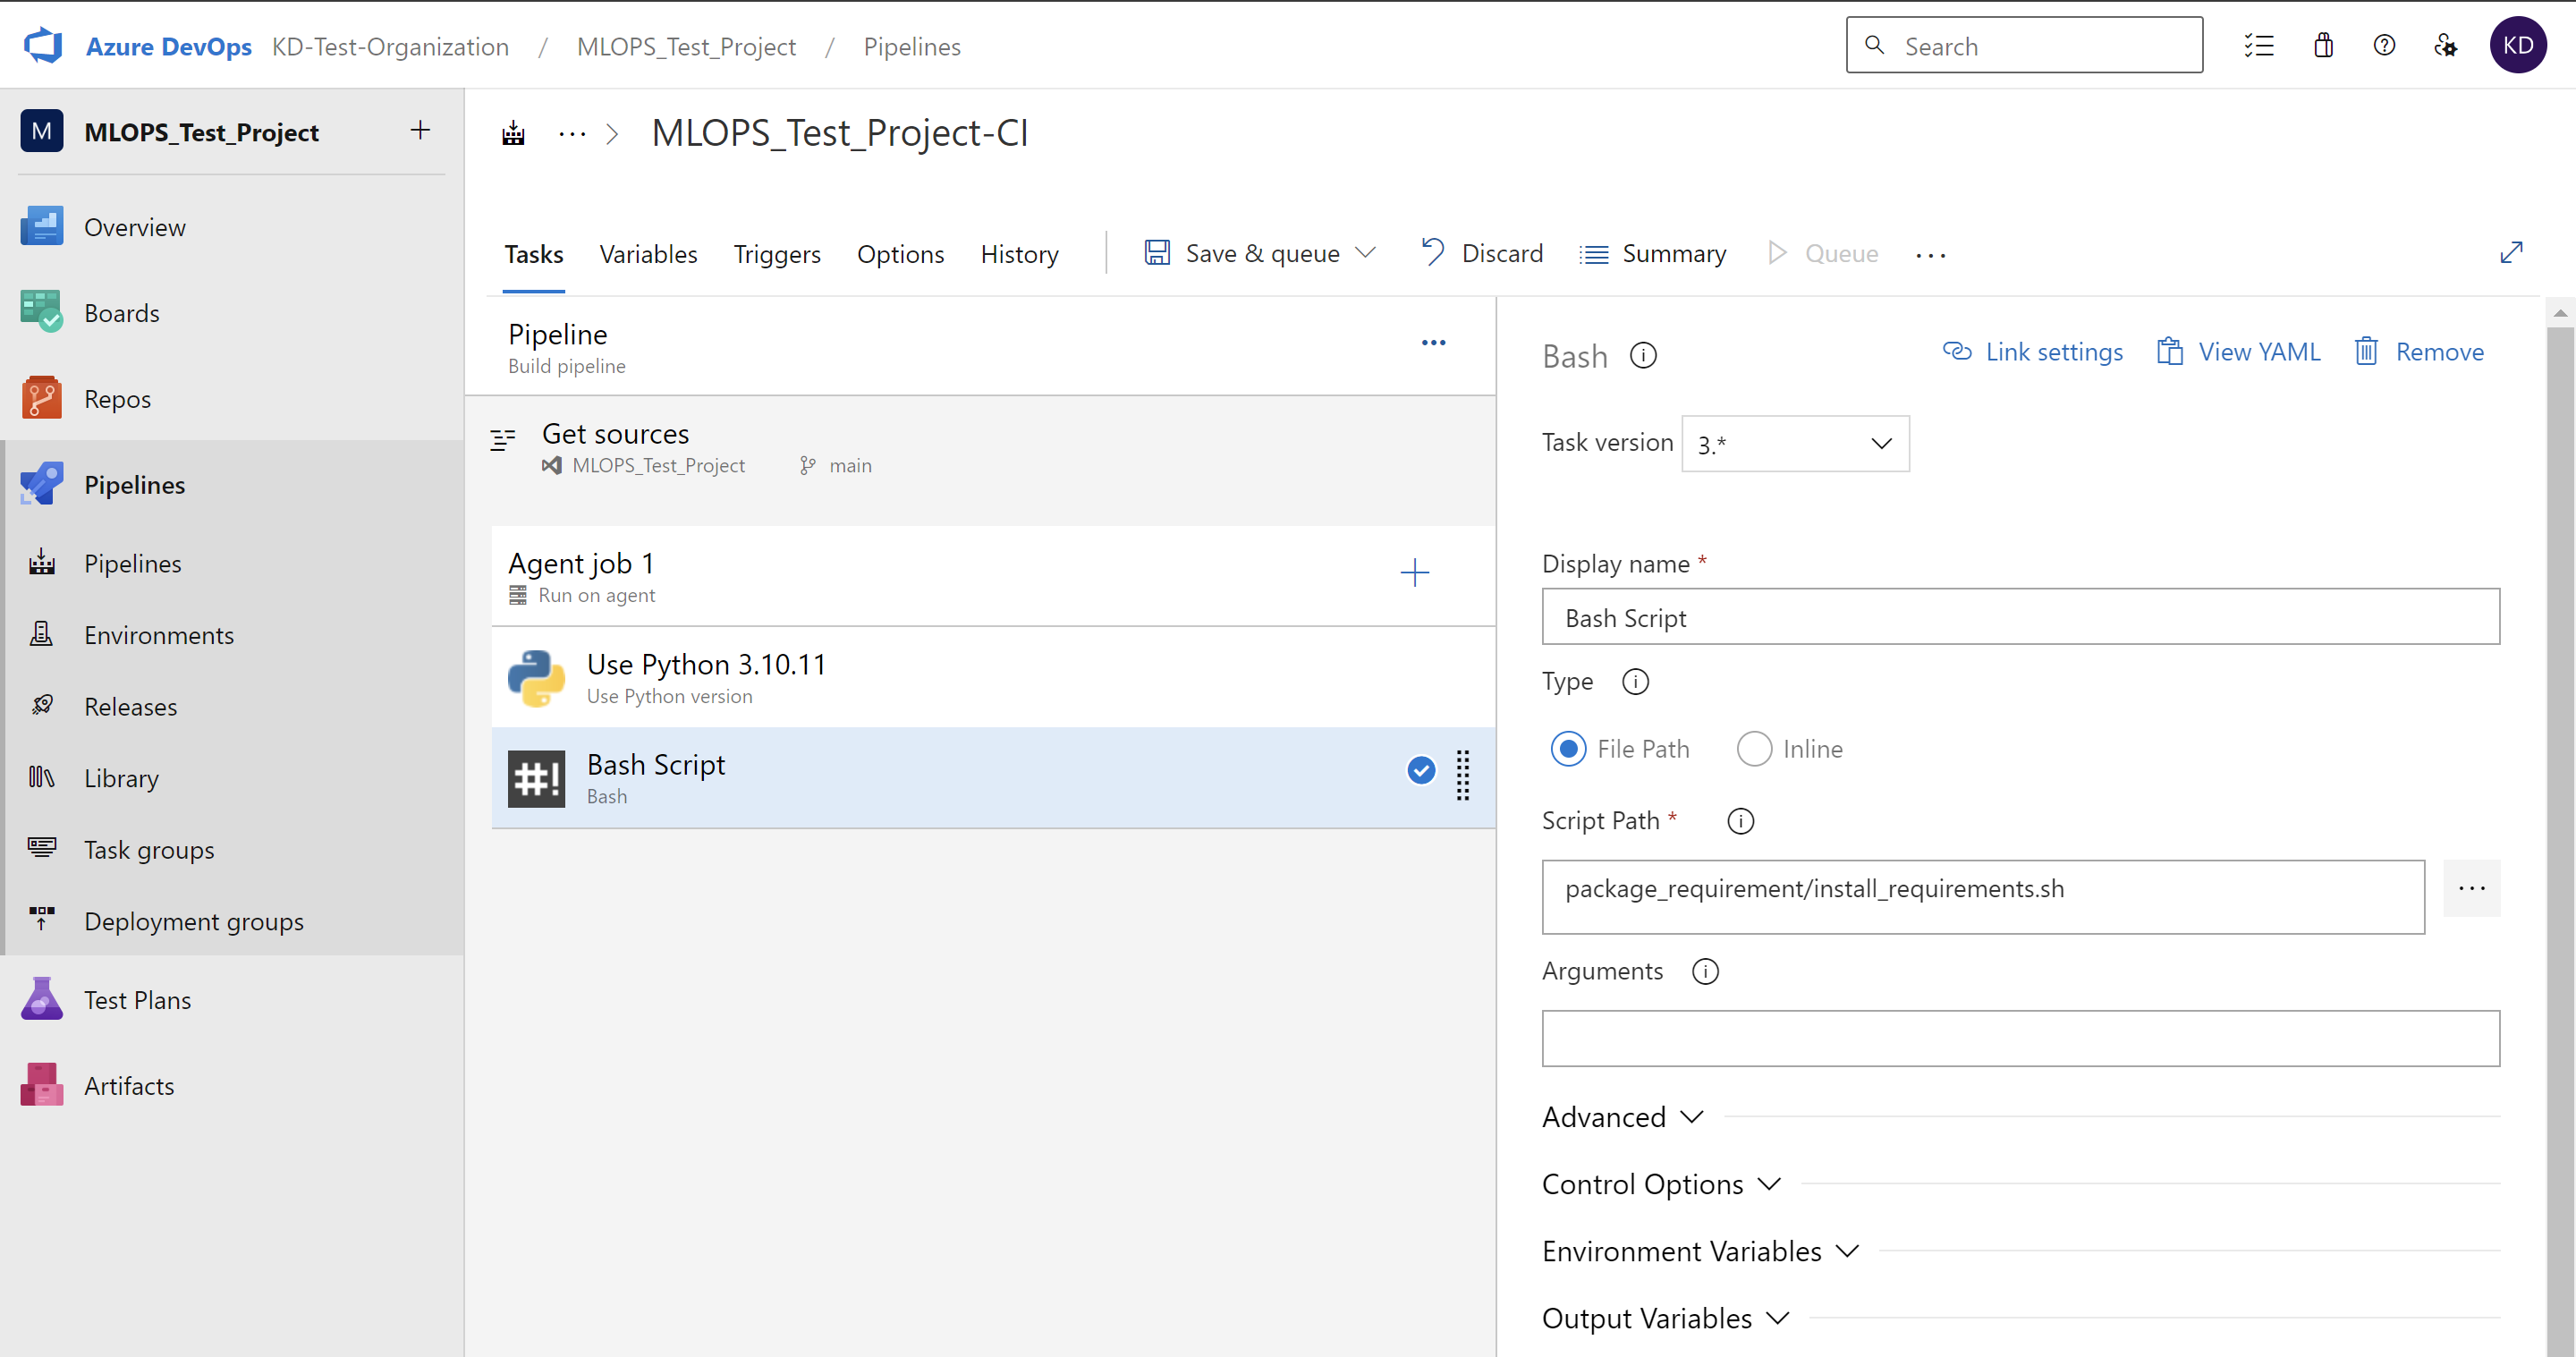

### STEP 3 : Run unit tests and show results

### STEP 4 : Create Azure ML Workspace

First define some variable names in the azure pipelines -> Library -> Variable Group. In this way you won't be needing to specify the same in the yaml file. Security threat is avoided in this way and it's the best practice. <br><br>
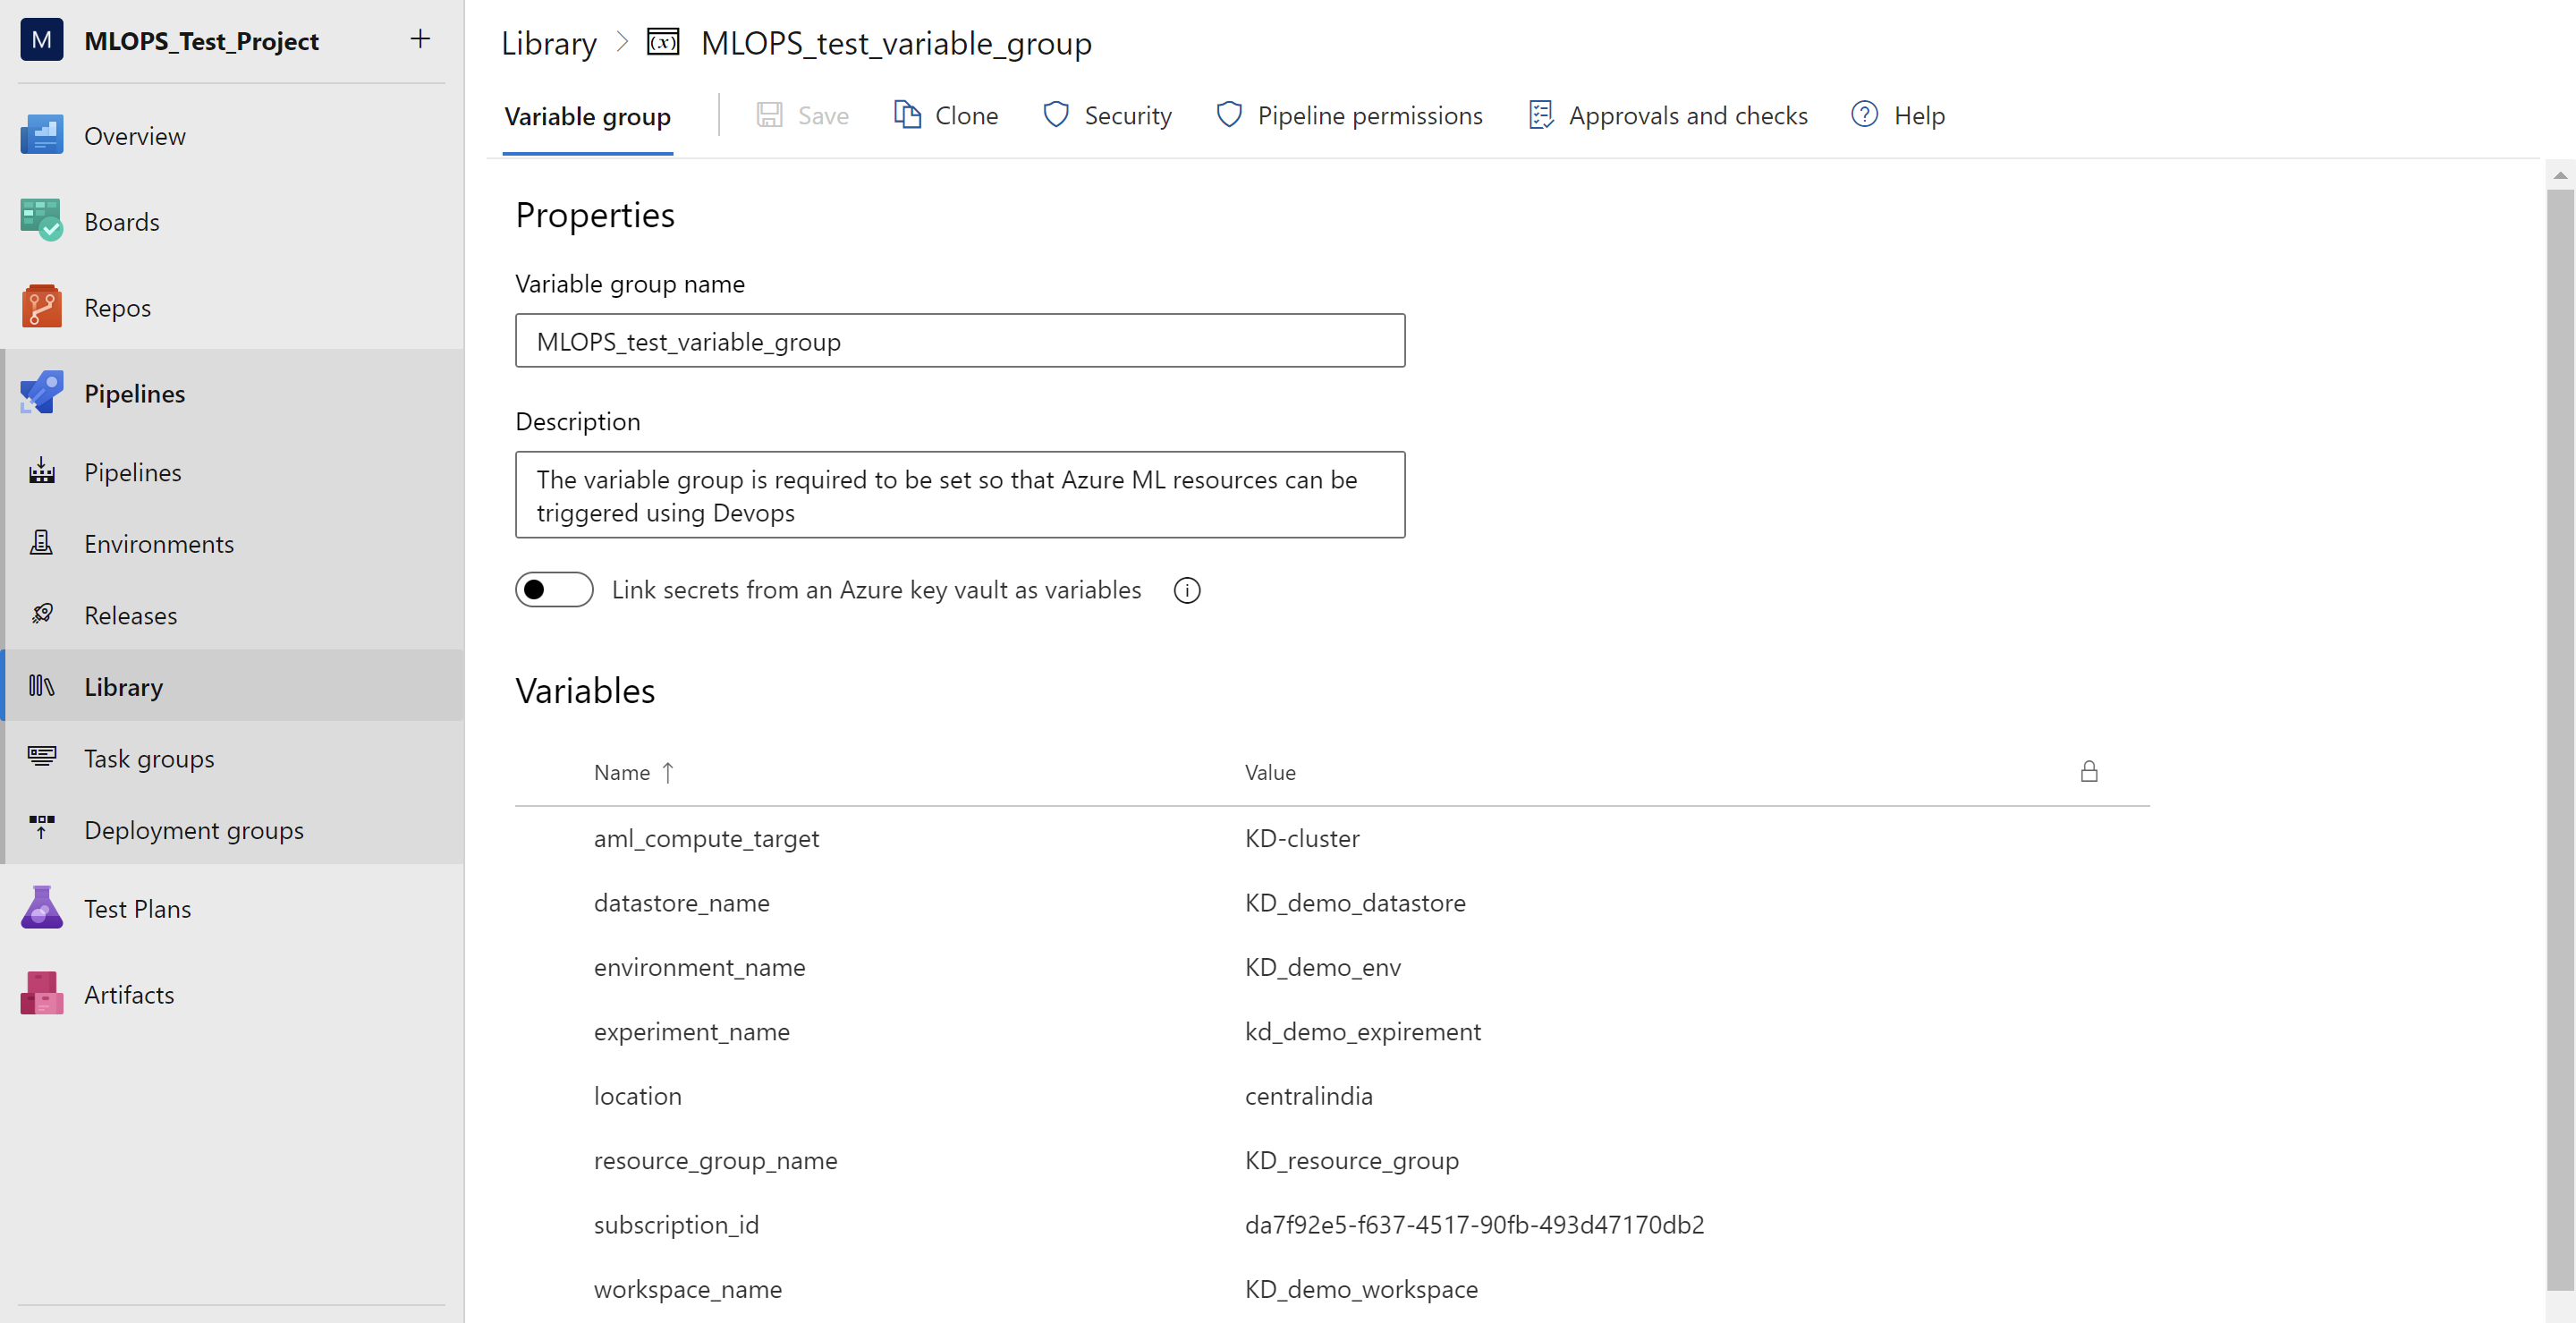
<br><br>

Also link the variable group when they are to be referenced in any of the components in azure ML Pipeline.<br>
variables -> Variables Group -> Link variable Group -> Link <br><br>

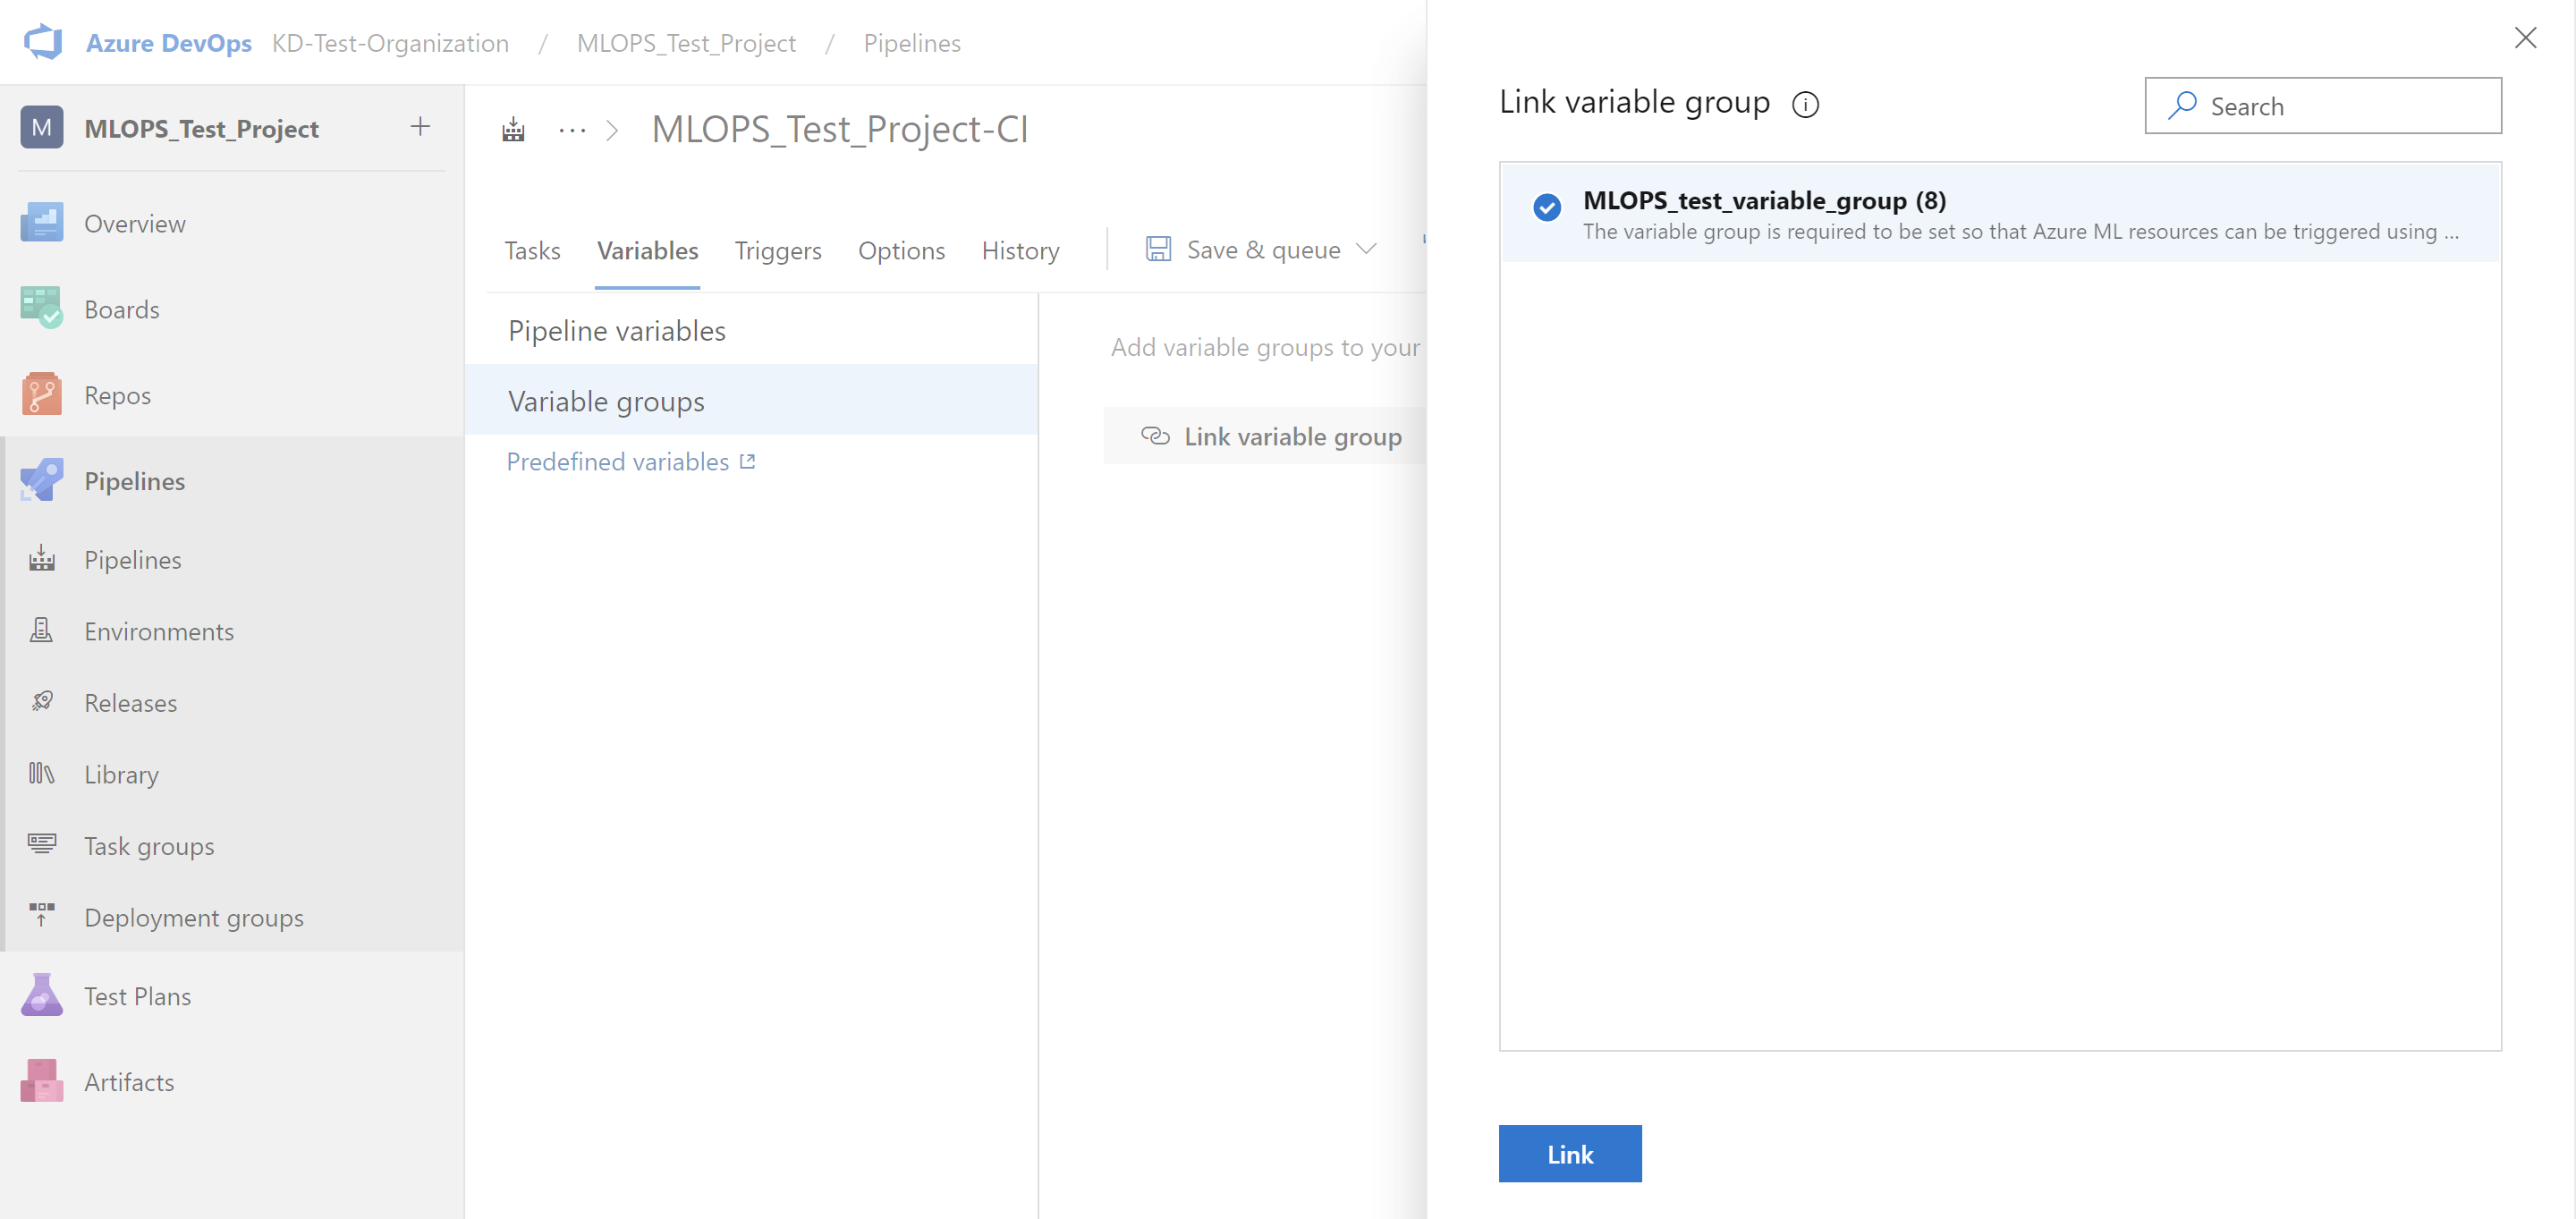<br><br>
Add a Azure CLI component to the pipeline -> Select proper service connection -> Choose script type as Shell -> Write Inline script to create workspace in AzureML.<br> Azure CLI command to create workspace : `az ml workspace create -g $[ variablegroups.MLOPS_test_variable_group.resource_group_name ] - w $[variablegroups.MLOPS_test_variable_group.workspace_name] -l $[variablegroups.MLOPS_test_variable_group.location]  --exist-ok --yes`<br>

As we are using the variables of the variable group, we need to referencee the same using the manner : $[variablegroups.MLOPS_test_variable_group.<variable_name>]

YAML :

    steps:
    - task: AzureCLI@2
    displayName: 'Azure CLI '
    inputs:
        azureSubscription: 'kd_service_connection'
        scriptType: bash
        scriptLocation: inlineScript
        inlineScript: 'az ml workspace create -g $[ variablegroups.MLOPS_test_variable_group.resource_group_name ] - w $[variablegroups.MLOPS_test_variable_group.workspace_name] -l $[variablegroups.MLOPS_test_variable_group.location]  --exist-ok --yes '
        addSpnToEnvironment: true
        useGlobalConfig: true

### STEP 5 : Create Compute Target

Azure CLI Command : <br> `az ml computetarget create amlcompute --name $[variablegroups.MLOPS_test_variable_group.aml_compute_target ] --vm-size $[variablegroups.MLOPS_test_variable_group.vm_size ] --workspace-name $[variablegroups.MLOPS_test_variable_group.workspace_name ] --resource-group $[variablegroups.MLOPS_test_variable_group.resource_group_name ] --max-nodes $[variablegroups.MLOPS_test_variable_group.max_compute_node ]  --min-nodes $[variablegroups.MLOPS_test_variable_group.min_compute_node ] `
<br><br>
YAML:

    steps:
    - task: AzureCLI@2
    displayName: 'Create Compute Cluster'
    inputs:
        azureSubscription: 'kd_service_connection'
        scriptType: bash
        scriptLocation: inlineScript
        inlineScript: 'az ml computetarget create amlcompute --name $[variablegroups.MLOPS_test_variable_group.aml_compute_target ] --vm-size $[variablegroups.MLOPS_test_variable_group.vm_size ] --workspace-name $[variablegroups.MLOPS_test_variable_group.workspace_name ] --resource-group $[variablegroups.MLOPS_test_variable_group.resource_group_name ] --max-nodes $[variablegroups.MLOPS_test_variable_group.max_compute_node ]  --min-nodes $[variablegroups.MLOPS_test_variable_group.min_compute_node ]'

### STEP 6 : Create Azure DataStore

    trigger:
    branches:
        include:
        - master

    pool:
    vmImage: 'ubuntu-latest'

    steps:
    - task: AzureCLI@2
    displayName: 'Azure CLI'
    inputs:
        azureSubscription: '<your_azure_subscription>'
        scriptType: 'bash'
        scriptLocation: 'inlineScript'
        inlineScript: |
        # Authenticate with Azure
        az login --service-principal -u <service_principal_id> -p <service_principal_secret> --tenant <tenant_id>

        # Fetch data from your Azure repository (e.g., Git)
        az repos list --org <azure_devops_organization> --project <azure_devops_project> --repository <repository_name>

        # Upload data to Azure Datastore (e.g., Azure Blob Storage)
        az storage blob upload --account-name <blob_storage_account_name> --account-key <blob_storage_account_key> --container-name <container_name> --type block --name <destination_blob_name> --source <source_file_path>


### STEP 7: Train the Model

First create a directory to store metadata and model with mkdir of bash. <br>
YAML : 

    steps:
    - bash: |
    mkdir metadata && mkdir models
    
    displayName: 'Store metadata for model'

Secondly we will run the train.py python file that would make the actual model.fit() command on the data.Here we assume that the conda_environment.yaml file is kept in pipeline folder of the git repo and the train.py is kept in training folder. That is why we defined the working directory as training in the last line of YAML file. <br><br>
CLI code :<br>
`az ml run submit-script --resource-group $[variablegroups.MLOPS_test_variable_group.resource_group_name] --workspace-name $[variablegroups.MLOPS_test_variable_group.workspace_name] --experiment-name $[variablegroups.MLOPS_test_variable_group.experiment_name] --ct $[variablegroups.MLOPS_test_variable_group.aml_compute_target] --conda-dependencies .pipeline/conda-dependencies.yml --output-metadata-file /metadata/run.json train/trainModel.py`<br><br>

YAML:

    steps:
    - task: AzureCLI@2
    displayName: 'Training Model'
    inputs:
        azureSubscription: 'kd_service_connection'
        scriptType: bash
        scriptLocation: inlineScript
        inlineScript: 'az ml run submit-script --resource-group $[variablegroups.MLOPS_test_variable_group.resource_group_name] --workspace-name $[variablegroups.MLOPS_test_variable_group.workspace_name] --experiment-name $[variablegroups.MLOPS_test_variable_group.experiment_name] --ct $[variablegroups.MLOPS_test_variable_group.aml_compute_target] --conda-dependencies .pipeline/conda-dependencies.yml --output-metadata-file ./metadata/run.json trainModel.py'
        workingDirectory: training

### STEP 8: Register Model

Azure CLI :<br><br>
`az ml model register --name $[variablegroups.MLOPS_test_variable_group.model_name] --description "Diabetes Prediction ML Model" --workspace-name $[variablegroups.MLOPS_test_variable_group.workspace_name] --experiment-name $[variablegroups.MLOPS_test_variable_group.experiment_name] --resource-group $[variablegroups.MLOPS_test_variable_group.resource_name]--model-framework ScikirLearn --run-metadata-file /metadata/run.json --output-metadata-file /metadata/model.json --asset-path outputs/model/diebetic_model.pkl`

YAML:

    steps:
    - task: AzureCLI@2
    displayName: 'Registering Model'
    inputs:
        azureSubscription: 'kd_service_connection'
        scriptType: bash
        scriptLocation: inlineScript
        inlineScript: 'az ml model register --name $[variablegroups.MLOPS_test_variable_group.model_name] --description "Diabetes Prediction ML Model" --workspace-name $[variablegroups.MLOPS_test_variable_group.workspace_name] --experiment-name $[variablegroups.MLOPS_test_variable_group.experiment_name] --resource-group $[variablegroups.MLOPS_test_variable_group.resource_name]--model-framework ScikirLearn --run-metadata-file /metadata/run.json --output-metadata-file /metadata/model.json --asset-path outputs/model/diebetic_model.pkl'
